## Exercise 8.1

The notebook for this chapter is chap08.ipynb. Read through it and run the code.
It contains an interactive widget that lets you experiment with the parameters of the Gaussian window to see what effect they have on the cutoff frequency.
What goes wrong when you increase the width of the Gaussian, std, without increasing the number of elements in the window, M?

In [1]:
import os, numpy as np, matplotlib.pyplot as plt
from thinkdsp import decorate
if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/cpulover/signal-processing/blob/master/thinkdsp.py

In [2]:
# suppress scientific notation for small numbers
np.set_printoptions(precision=3, suppress=True)

### Smoothing

As the first example, I'll look at [daily closing stock prices for Facebook](https://finance.yahoo.com/quote/FB/history?period1=1337299200&period2=1585353600&interval=1d&filter=history&frequency=1d), from its IPO on 2012-05-18 to 2020-03-27 (note: the dataset includes only trading days )

In [3]:
if not os.path.exists('FB.csv'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/FB.csv

In [4]:
import pandas as pd

df = pd.read_csv('FB.csv', header=0, parse_dates=[0])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [5]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1972,2020-03-23,149.660004,152.309998,142.250000,148.100006,148.100006,29830800
1973,2020-03-24,155.210007,161.309998,152.570007,160.979996,160.979996,30440400
1974,2020-03-25,158.919998,162.990005,153.059998,156.210007,156.210007,35184300
1975,2020-03-26,158.250000,164.000000,157.020004,163.339996,163.339996,26556800
1976,2020-03-27,158.199997,160.089996,154.750000,156.789993,156.789993,24861900


Extract the close prices and days since start of series:

In [6]:
close = df['Close']
dates = df['Date']
days = (dates - dates[0]) / np.timedelta64(1,'D')

Make a window to compute a 30-day moving average and convolve the window with the data.  The `valid` flag means the convolution is only computed where the window completely overlaps with the signal.

In [7]:
M = 30
window = np.ones(M)
window /= sum(window)
smoothed = np.convolve(close, window, mode='valid')
smoothed_days = days[M//2: len(smoothed) + M//2]

Plot the original and smoothed signals.

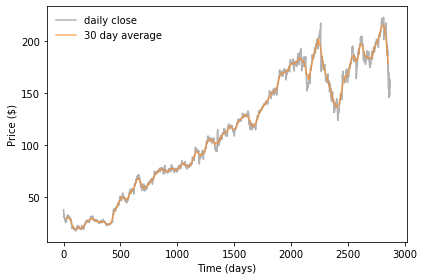

In [8]:
plt.plot(days, close, color='gray', alpha=0.6, label='daily close')
plt.plot(smoothed_days, smoothed, color='C1', alpha=0.6, label='30 day average')

decorate(xlabel='Time (days)', ylabel='Price ($)')

## Smoothing sound signals

Generate a 440 Hz sawtooth signal.

In [9]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(freq=440)
wave = signal.make_wave(duration=1.0, framerate=44100)
wave.make_audio()

Make a moving average window.

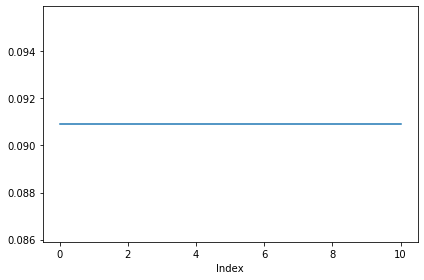

In [10]:
window = np.ones(11)
window /= sum(window)
plt.plot(window)
decorate(xlabel='Index')

Plot the wave.

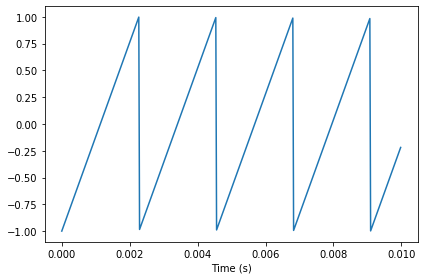

In [11]:
segment = wave.segment(duration=0.01)
segment.plot()
decorate(xlabel='Time (s)')

Pad the window so it's the same length as the signal, and plot it.

In [12]:
def zero_pad(array, n):
    """Extends an array with zeros.

    array: NumPy array
    n: length of result

    returns: new NumPy array
    """
    res = np.zeros(n)
    res[:len(array)] = array
    return res

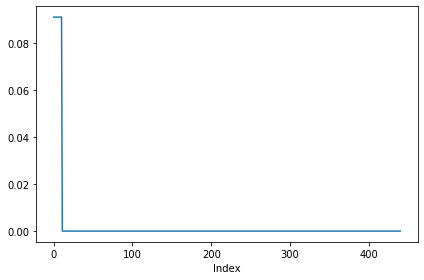

In [13]:
N = len(segment)
padded = zero_pad(window, N)
plt.plot(padded)
decorate(xlabel='Index')

Apply the window to the signal (with lag=0).

In [14]:
prod = padded * segment.ys
np.sum(prod)

-0.9001814882032255

Compute a convolution by rolling the window to the right.

In [15]:
smoothed = np.zeros(N)
rolled = padded.copy()
for i in range(N):
    smoothed[i] = sum(rolled * segment.ys)
    rolled = np.roll(rolled, 1)

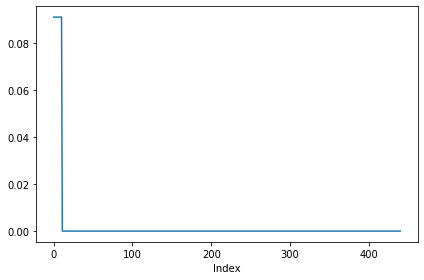

In [16]:
plt.plot(rolled)
decorate(xlabel='Index')

Plot the result of the convolution and the original.

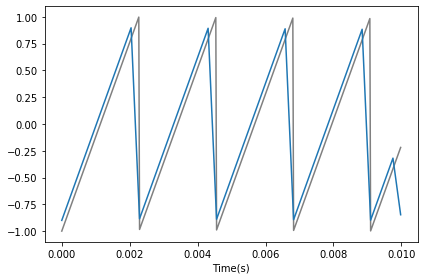

In [17]:
from thinkdsp import Wave

segment.plot(color='gray')
smooth = Wave(smoothed, framerate=wave.framerate)
smooth.plot()
decorate(xlabel='Time(s)')

Compute the same convolution using `numpy.convolve`.

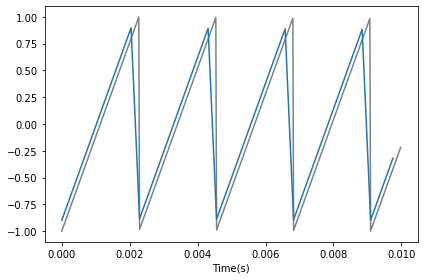

In [18]:
segment.plot(color='gray')
ys = np.convolve(segment.ys, window, mode='valid')
smooth2 = Wave(ys, framerate=wave.framerate)
smooth2.plot()
decorate(xlabel='Time(s)')

## Frequency domain

Let's see what's happening in the frequency domain.

Compute the smoothed wave using `np.convolve`, which is much faster than my version above.

In [19]:
convolved = np.convolve(wave.ys, window, mode='same')
smooth = Wave(convolved, framerate=wave.framerate)
smooth.make_audio()

Plot spectrums of the original and smoothed waves:

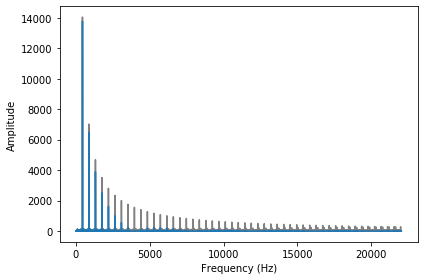

In [20]:
spectrum = wave.make_spectrum()
spectrum.plot(color='gray')

spectrum2 = smooth.make_spectrum()
spectrum2.plot()

decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

For each harmonic, compute the ratio of the amplitudes before and after smoothing.

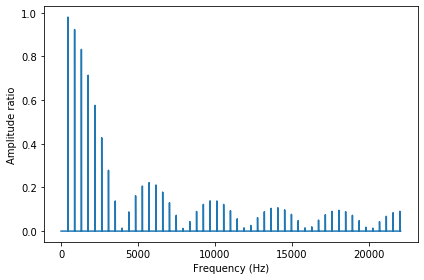

In [21]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps    
ratio[amps<280] = 0

plt.plot(ratio)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')

Plot the ratios again, but also plot the FFT of the window.

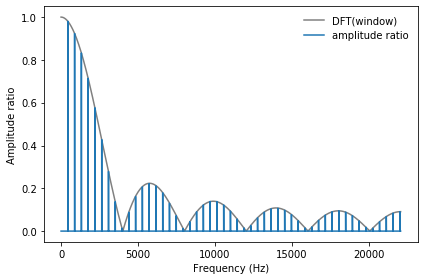

In [22]:
padded =  zero_pad(window, len(wave))
dft_window = np.fft.rfft(padded)

plt.plot(np.abs(dft_window), color='gray', label='DFT(window)')
plt.plot(ratio, label='amplitude ratio')

decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')

### Gaussian window

Let's compare boxcar and Gaussian windows.

Make the boxcar window.

In [23]:
boxcar = np.ones(11)
boxcar /= sum(boxcar)

Make the Gaussian window.

In [24]:
import scipy.signal

gaussian = scipy.signal.gaussian(M=11, std=2)
gaussian /= sum(gaussian)

Plot the two windows.

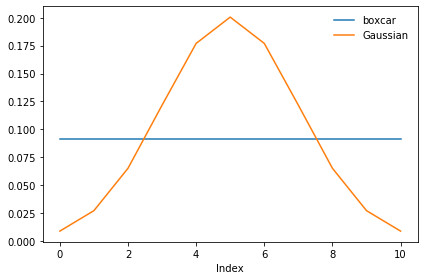

In [25]:
plt.plot(boxcar, label='boxcar')
plt.plot(gaussian, label='Gaussian')
decorate(xlabel='Index')

Convolve the square wave with the Gaussian window.

In [26]:
ys = np.convolve(wave.ys, gaussian, mode='same')
smooth = Wave(ys, framerate=wave.framerate)
spectrum2 = smooth.make_spectrum()

Compute the ratio of the amplitudes.

In [27]:
amps = spectrum.amps
amps2 = spectrum2.amps
ratio = amps2 / amps    
ratio[amps<560] = 0

Compute the FFT of the window.

In [28]:
padded =  zero_pad(gaussian, len(wave))
dft_gaussian = np.fft.rfft(padded)

Plot the ratios and the FFT of the window.

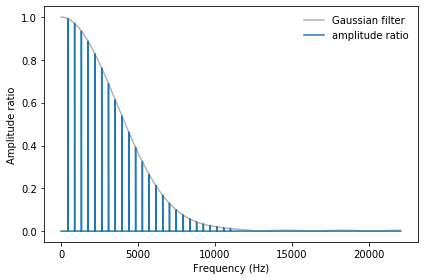

In [29]:
plt.plot(np.abs(dft_gaussian), color='0.7', label='Gaussian filter')
plt.plot(ratio, label='amplitude ratio')

decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')

Combine the preceding example into one big function so we can interact with it.

In [30]:
from thinkdsp import SquareSignal

def plot_filter(M=11, std=2):
    signal = SquareSignal(freq=440)
    wave = signal.make_wave(duration=1, framerate=44100)
    spectrum = wave.make_spectrum()

    gaussian = scipy.signal.gaussian(M=M, std=std)
    gaussian /= sum(gaussian)

    ys = np.convolve(wave.ys, gaussian, mode='same')
    smooth =  Wave(ys, framerate=wave.framerate)
    spectrum2 = smooth.make_spectrum()

    # plot the ratio of the original and smoothed spectrum
    amps = spectrum.amps
    amps2 = spectrum2.amps
    ratio = amps2 / amps    
    ratio[amps<560] = 0

    # plot the same ratio along with the FFT of the window
    padded =  zero_pad(gaussian, len(wave))
    dft_gaussian = np.fft.rfft(padded)

    plt.plot(np.abs(dft_gaussian), color='gray', label='Gaussian filter')
    plt.plot(ratio, label='amplitude ratio')

    decorate(xlabel='Frequency (Hz)', ylabel='Amplitude ratio')
    plt.show()

Try out different values of `M` and `std`.

In [31]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider = widgets.IntSlider(min=2, max=100, value=11)
slider2 = widgets.FloatSlider(min=0, max=20, value=2)
interact(plot_filter, M=slider, std=slider2);

interactive(children=(IntSlider(value=11, description='M', min=2), FloatSlider(value=2.0, description='std', m…

When increasing the width of the Gaussian (std) without increasing the number of elements in the window (M), we can see that the ratio drops off faster. Besides, above the cutoff, the ratio bounces around between 0 and a very small value.